In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
# from google.colab import drive
import matplotlib.pyplot as plt
import random
import time

In [ ]:
# mount Google Drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# define paths
# DATASET_DIR = "/content/drive/My Drive/final_dataset"  # Update Google Drive path accordingly
DATASET_DIR = './data'
# load the dataset from .npy files
train_images = np.load(os.path.join(DATASET_DIR, "train_images.npy"))
train_labels = np.load(os.path.join(DATASET_DIR, "train_labels.npy"))
val_images = np.load(os.path.join(DATASET_DIR, "val_images.npy"))
val_labels = np.load(os.path.join(DATASET_DIR, "val_labels.npy"))
test_images = np.load(os.path.join(DATASET_DIR, "test_images.npy"))
test_labels = np.load(os.path.join(DATASET_DIR, "test_labels.npy"))

# Check dataset sizes
print(f"Train: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Validation: {val_images.shape}, Labels: {val_labels.shape}")
print(f"Test: {test_images.shape}, Labels: {test_labels.shape}")

Train: (3277, 28, 28), Labels: (3277,)
Validation: (1093, 28, 28), Labels: (1093,)
Test: (1093, 28, 28), Labels: (1093,)


In [ ]:
# defined class names
CLASS_NAMES = ["apple", "bee", "cat", "eyeglasses", "fish", "flower", "house", "pencil", "pizza"]

In [ ]:
# function to visualize random images from the dataset
def visualize_samples(images, labels, class_names, num_samples=10):
    indices = random.sample(range(len(images)), num_samples)
    selected_images = images[indices]
    selected_labels = labels[indices]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(selected_images[i], cmap="gray")
        ax.set_title(class_names[selected_labels[i]])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

Training Set Samples:


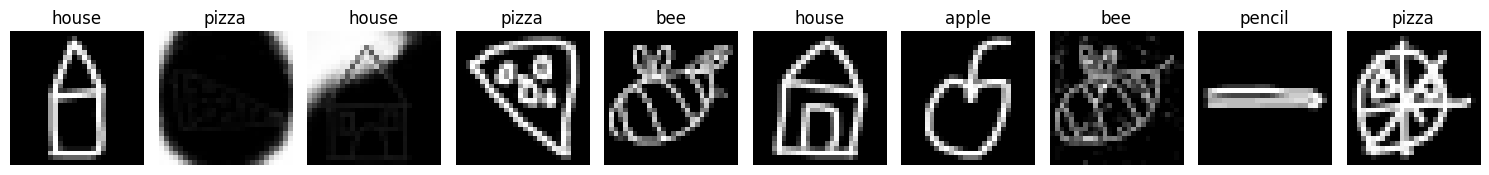

In [ ]:
# visualize random samples from training set
print("Training Set Samples:")
visualize_samples(train_images, train_labels, CLASS_NAMES)

In [ ]:
# Convert 28x28 grayscale images to Pytorch Pretrained Models format
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize according to Pytorch specifications
])

class CustomDataset(Dataset):
    def __init__(self, image_list, labels, transform=None):
        self.image_list = image_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img = self.image_list[idx]
        label = self.labels[idx]

        # Convert NumPy array to PIL image, apply transformations
        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Create dataset
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
val_dataset = CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

# Check dataset sizes
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 3277, Val: 1093, Test: 1093


## Baseline Models

3 baseline models with widely known architectures will be chosen. This allows for an effective comparison between our model and other popular architectures Pretrained weights will be used in both the baseline models and our model.

3 chosen architecutres:
1. MobileNetV2
2. EfficientNet-B0
3. ResNet-50

| Model  | No. Parameters  | Acc@1  | Acc@5 |
|---|---|---|---|
| MobileNetV2  | ~3.4M  | 71.658 | 90.15 |
| EfficientNet-B0	  | ~5.3  |77.1%	|93.3%|
| ResNet-50  | ~25.6M  | 76.2%	| 92.9% |

Acc@1 and Acc@5 scores were tested on the ImageNet1K dataset and found in Pytorch's documentation.

In [ ]:
def get_accuracy(model, data_loader, device):
    correct, total = 0, 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return 100 * correct / total  # Return accuracy percentage

In [ ]:
def train(model, train_dataset, val_dataset, device, batch_size=32, num_epochs=1, learning_rate=0.01, patience=20):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []

    best_val_acc = 0
    patience_counter = 0

    # training
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader, device)) # compute training accuracy
            current_val_acc = get_accuracy(model, val_loader, device)  # compute validation accuracy
            val_acc.append(current_val_acc)
            n += 1

            if (n % 5 == 0):
                print(f"Time: {time.time() - start_time:.2f}s    Iteration {n}      Loss: {loss.item()}, Train acc: {train_acc[-1]}, Val acc: {val_acc[-1]}")

            # Check for improvement in validation accuracy
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                patience_counter = 0  # Reset patience counter
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping at iteration {n} due to no improvement in validation accuracy for {patience} consecutive iterations.")
                checkpoint_path = f"{model.name}_checkpoint_{n}.pth"
                torch.save(model.state_dict(), checkpoint_path)
                print(f"{model.name} checkpoint saved at iteration {n} to {checkpoint_path}")
                # plotting
                plt.title("Training Curve")
                plt.plot(iters, losses, label="Train")
                plt.xlabel("Iterations")
                plt.ylabel("Loss")
                plt.show()

                plt.title("Training Curve")
                plt.plot(iters, train_acc, label="Train")
                plt.plot(iters, val_acc, label="Validation")
                plt.xlabel("Iterations")
                plt.ylabel("Training Accuracy")
                plt.legend(loc='best')
                plt.show()

                print("Final Training Accuracy: {}".format(train_acc[-1]))
                print("Final Validation Accuracy: {}".format(val_acc[-1]))
                return

            # Save the model checkpoint every 20 iterations
            if (n % 20 == 0):
                checkpoint_path = f"{model.name}_checkpoint_{n}.pth"
                torch.save(model.state_dict(), checkpoint_path)
                print(f"{model.name} checkpoint saved at iteration {n} to {checkpoint_path}")

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### MobileNet V2

In [ ]:
# Load MobileNetV2 with pretrained weights
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v2.name = "mobilenet_v2" # providing a name for later ref

# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
mobilenet_v2 = mobilenet_v2.to(device)

c:\Users\hanna\Downloads\Lab3 Dataset\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hanna\Downloads\Lab3 Dataset\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [ ]:
train(mobilenet_v2, train_dataset, val_dataset, device, batch_size=32, num_epochs=10, learning_rate=0.01)

Time: 40.67s    Iteration 5      Loss: 3.709963798522949, Train acc: 52.731156545621, Val acc: 50.41171088746569
Time: 80.81s    Iteration 10      Loss: 1.1587584018707275, Train acc: 59.04790967348184, Val acc: 56.907593778591036
Time: 122.43s    Iteration 15      Loss: 0.45276859402656555, Train acc: 60.146475434848945, Val acc: 58.554437328453794
Time: 164.84s    Iteration 20      Loss: 1.3336728811264038, Train acc: 69.66737870003051, Val acc: 68.06953339432754
mobilenet_v2 checkpoint saved at iteration 20 to mobilenet_v2_checkpoint_20.pth
Time: 205.06s    Iteration 25      Loss: 0.796039879322052, Train acc: 69.20964296612756, Val acc: 68.80146386093321
Time: 245.42s    Iteration 30      Loss: 1.3353804349899292, Train acc: 74.15318889227953, Val acc: 70.26532479414456
Time: 285.25s    Iteration 35      Loss: 1.5477001667022705, Train acc: 71.62038449801648, Val acc: 71.08874656907594
Time: 324.99s    Iteration 40      Loss: 0.3711123764514923, Train acc: 73.87854745193775, Val ac

KeyboardInterrupt: 

Best saved model iteration: 360

Time: 17391.36s    Iteration 360      Loss: 0.03521396592259407, Train acc: 96.24656698199573, Val acc: 90.30192131747484


The above training was interrupted as overfitting was beginning to occur. Validation accuracy was decreasing after iteration 285 and loss was increasing.

The train function was then modified to include early stopping.

In [ ]:
torch.cuda.empty_cache()

### EfficientNetB0

In [ ]:
# Load EfficientNet-B0
efficientnet_b0 = models.efficientnet_b0(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_b0 = efficientnet_b0.to(device)
efficientnet_b0.name = "efficientnet_b0"

c:\Users\hanna\Downloads\Lab3 Dataset\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hanna\Downloads\Lab3 Dataset\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\hanna/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100.0%


In [ ]:
train(efficientnet_b0, train_dataset, val_dataset, device, batch_size=32, num_epochs=10, learning_rate=0.01)

Time: 395.43s    Iteration 5      Loss: 6.45145320892334, Train acc: 1.4342386328959413, Val acc: 1.280878316559927
Time: 708.43s    Iteration 10      Loss: 4.403704643249512, Train acc: 34.20811718034788, Val acc: 33.11985361390668
Time: 1974.17s    Iteration 15      Loss: 1.8374903202056885, Train acc: 60.2990540128166, Val acc: 58.737419945105216
Time: 2224.86s    Iteration 20      Loss: 1.518885850906372, Train acc: 71.92554165395178, Val acc: 66.97163769441903
efficientnet_b0 checkpoint saved at iteration 20 to efficientnet_b0_checkpoint_20.pth
Time: 2463.52s    Iteration 25      Loss: 0.9179365038871765, Train acc: 74.06164174549893, Val acc: 70.53979871912168
Time: 2701.17s    Iteration 30      Loss: 0.960216760635376, Train acc: 74.48886176380836, Val acc: 71.27172918572735
Time: 2939.98s    Iteration 35      Loss: 0.5822017192840576, Train acc: 79.09673481843149, Val acc: 75.02287282708143
Time: 3176.92s    Iteration 40      Loss: 1.2741758823394775, Train acc: 81.202319194385

Best saved model iteration: 120

Time: 39999.83s    Iteration 120      Loss: 0.20342004299163818, Train acc: 93.56118400976503, Val acc: 89.47849954254346

### ResNet-50

In [ ]:
resnet50 = models.resnet50(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)
resnet50.name = "resnet50"

c:\Users\hanna\Downloads\Lab3 Dataset\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\hanna/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [ ]:
train(resnet50, train_dataset, val_dataset, device, batch_size=32, num_epochs=10, learning_rate=0.01)

Time: 718.40s    Iteration 5      Loss: 2.259995937347412, Train acc: 53.799206591394565, Val acc: 52.881976212259836
Time: 1435.70s    Iteration 10      Loss: 1.4081059694290161, Train acc: 64.38815990234971, Val acc: 62.12259835315645
Time: 2152.69s    Iteration 15      Loss: 1.1768490076065063, Train acc: 65.88342996643271, Val acc: 64.22689844464776
Time: 2870.03s    Iteration 20      Loss: 1.3846514225006104, Train acc: 68.29417149832163, Val acc: 66.97163769441903
resnet50 checkpoint saved at iteration 20 to resnet50_checkpoint_20.pth
Time: 3587.28s    Iteration 25      Loss: 1.0620918273925781, Train acc: 69.60634726884345, Val acc: 65.87374199451052
Time: 4304.76s    Iteration 30      Loss: 1.1780158281326294, Train acc: 73.11565456209948, Val acc: 71.08874656907594
Time: 5022.00s    Iteration 35      Loss: 0.7942788004875183, Train acc: 79.3103448275862, Val acc: 75.38883806038426
Time: 5740.77s    Iteration 40      Loss: 0.4555281102657318, Train acc: 80.16478486420506, Val a

KeyboardInterrupt: 

The above training was interrupted as iterations 46-50 took beyond 12h of training. ResNet50 is too large to be trained with a single GPU.

### Get training plots

In [ ]:
import re

In [ ]:
def parse_log_file(log_file):
    iterations = []
    loss_values = []
    train_acc_values = []
    val_acc_values = []

    with open(log_file, 'r') as f:
        for line in f:
            match = re.search(r'Iteration (\d+)\s+Loss: ([\d\.]+), Train acc: ([\d\.]+), Val acc: ([\d\.]+)', line)
            if match:
                iteration = int(match.group(1))
                loss = float(match.group(2))
                train_acc = float(match.group(3))
                val_acc = float(match.group(4))

                iterations.append(iteration)
                loss_values.append(loss)
                train_acc_values.append(train_acc)
                val_acc_values.append(val_acc)

    return iterations, loss_values, train_acc_values, val_acc_values

def plot_metrics(iterations, loss_values, train_acc_values, val_acc_values):
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(iterations, loss_values, linestyle='-', color='b', label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over Iterations')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(iterations, train_acc_values, linestyle='-', color='g', label='Train Accuracy')
    plt.plot(iterations, val_acc_values, linestyle='-', color='r', label='Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Iterations')
    plt.legend()

    plt.tight_layout()
    plt.show()

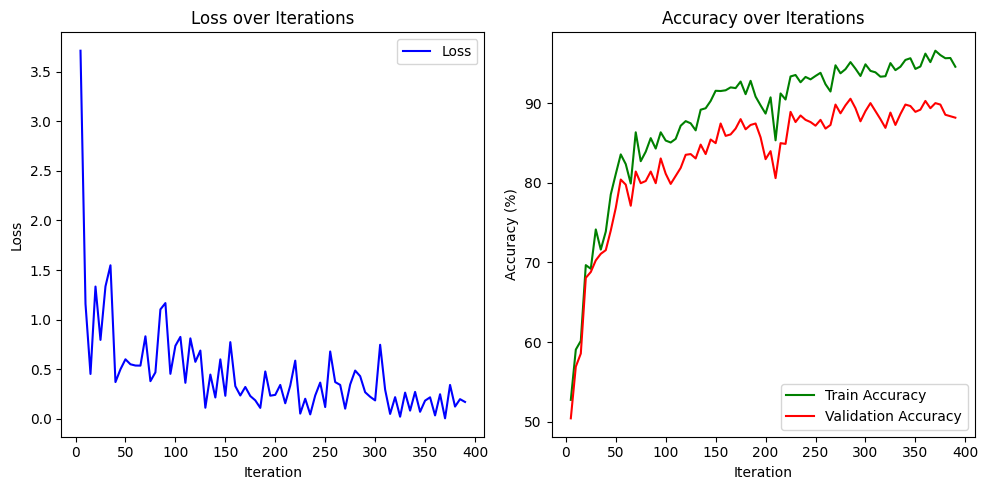

In [ ]:
log_file = 'log_files/mobilenet_v2.txt'
iterations, loss_values, train_acc_values, val_acc_values = parse_log_file(log_file)
plot_metrics(iterations, loss_values, train_acc_values, val_acc_values)

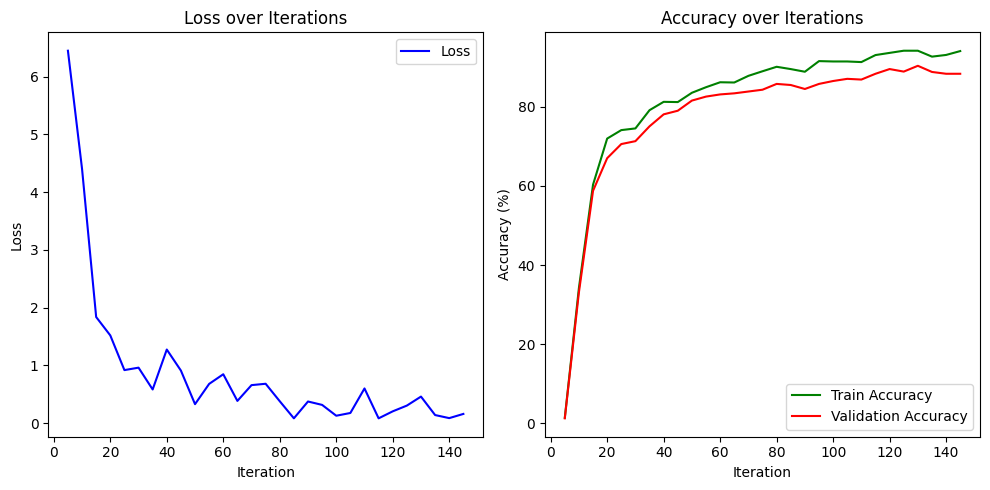

In [ ]:
log_file = 'log_files/efficientnet_b0.txt'
iterations, loss_values, train_acc_values, val_acc_values = parse_log_file(log_file)
plot_metrics(iterations, loss_values, train_acc_values, val_acc_values)

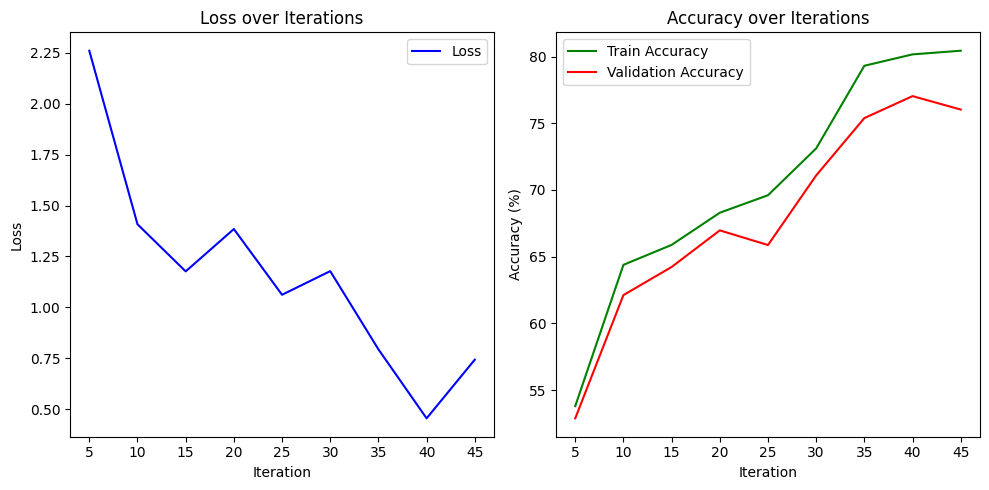

In [ ]:
log_file = 'log_files/resnet50.txt'
iterations, loss_values, train_acc_values, val_acc_values = parse_log_file(log_file)
plot_metrics(iterations, loss_values, train_acc_values, val_acc_values)

### Evaluation on Test Dataset

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
best_model_path = 'baseline_model_checkpoint_files/mobilenet_v2_checkpoint_360.pth'
best_model = models.mobilenet_v2(pretrained=True)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)
best_model_acc = get_accuracy(best_model, test_loader, device)

print(f'Best Model Test Acc: {best_model_acc}')

Best Model Test Acc: 93.22964318389754


### Best performing baseline model: MobileNetV2 with 360 iterations
Checkpoint file path: baseline_model_checkpoint_files/mobilenet_v2_checkpoint_360.pth

Hyperparameters:
- batch_size = 32
- learning_rate = 0.01

Metrics:
- Loss: 0.03521396592259407
- Train acc: 96.24656698199573
- Val acc: 90.30192131747484
- Test acc: 93.22964318389754

MobileNetV2 is the smallest of the three baseline model architectures trained, with approximately 3.4M parameters. It is possible that with the small input image size, more lightweight models perform better.


### Qualitative Performance

In [ ]:
def plot_samples(samples, class_names, title):
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
    fig.suptitle(title, fontsize=14)

    for i, (img, true_label, pred_label) in enumerate(samples):
        img.to("cpu")
        img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
        img = img.clip(0, 1)  # Clip values to valid range

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {class_names[true_label]}, Pred: {class_names[pred_label]}")

    plt.show()

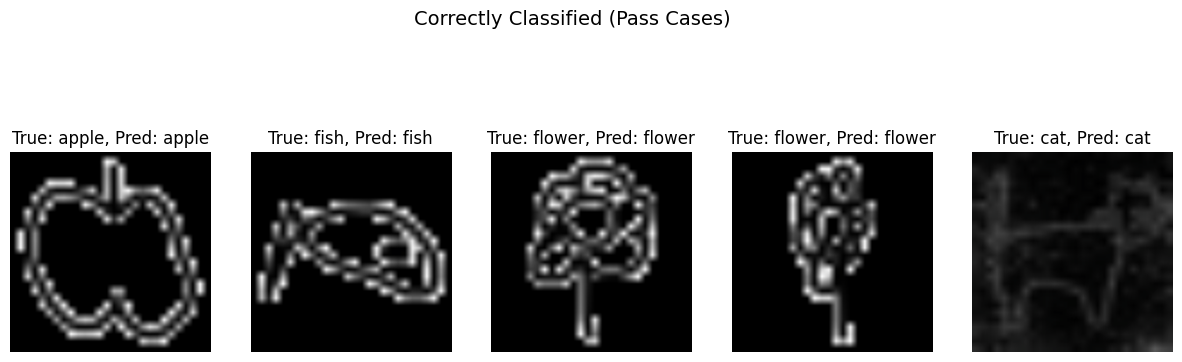

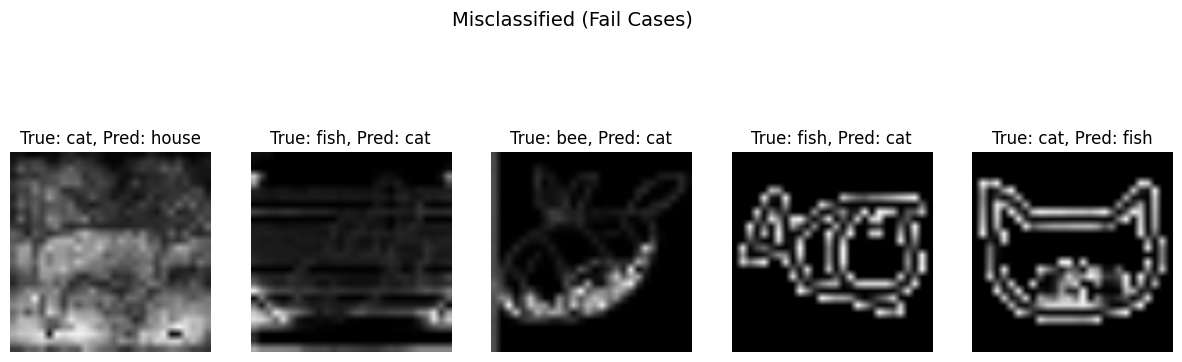

In [ ]:
# val_loader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)

# Store pass and fail cases
pass_cases, fail_cases = [], []

# Run inference and collect results
with torch.no_grad():
    for i, (image, label) in enumerate(val_loader):
        image = image.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)
        output = best_model(image)
        predicted = output.argmax(dim=1).item()

        # Store correctly classified (pass) and misclassified (fail) cases
        if predicted == label.item():
            pass_cases.append((image, label.item(), predicted))
        else:
            fail_cases.append((image, label.item(), predicted))

        # Stop after collecting enough samples
        if len(pass_cases) >= 10 and len(fail_cases) >= 10:
            break
# Show random samples of pass and fail cases
plot_samples(random.sample(pass_cases, min(5, len(pass_cases))), CLASS_NAMES, "Correctly Classified (Pass Cases)")
plot_samples(random.sample(fail_cases, min(5, len(fail_cases))), CLASS_NAMES, "Misclassified (Fail Cases)")
